# BPI Task 1
#### Prepared by Darius Vincent Ardales
#### Dataset Link: [Call-Center-Dataset](https://www.kaggle.com/datasets/akash1vishwakarma/call-center-dataset)

# 1. Importing Libraries

In [149]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer

# 2. Loading the Dataset

In [150]:
df = pd.read_excel('call_center.xlsx')
df.head()

,Call Id,Agent,Date,Time,Topic,Answered (Y/N),Resolved,Speed of answer in seconds,AvgTalkDuration,Satisfaction rating
0,ID0001,Diane,2021-01-01,09:12:58,Contract related,Y,Y,109.0,00:02:23,3.0
1,ID0002,Becky,2021-01-01,09:12:58,Technical Support,Y,N,70.0,00:04:02,3.0
2,ID0003,Stewart,2021-01-01,09:47:31,Contract related,Y,Y,10.0,00:02:11,3.0
3,ID0004,Greg,2021-01-01,09:47:31,Contract related,Y,Y,53.0,00:00:37,2.0
4,ID0005,Becky,2021-01-01,10:00:29,Payment related,Y,Y,95.0,00:01:00,3.0


In [151]:
print("Shape of the DataFrame:", df.shape)
df.info()

Shape of the DataFrame: (5000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Call Id                     5000 non-null   object 
 1   Agent                       5000 non-null   object 
 2   Date                        5000 non-null   object 
 3   Time                        5000 non-null   object 
 4   Topic                       5000 non-null   object 
 5   Answered (Y/N)              5000 non-null   object 
 6   Resolved                    5000 non-null   object 
 7   Speed of answer in seconds  4054 non-null   float64
 8   AvgTalkDuration             4054 non-null   object 
 9   Satisfaction rating         4054 non-null   float64
dtypes: float64(2), object(8)
memory usage: 390.8+ KB


# 3. Data Cleaning

## 3.1 Renaming Columns and Fixing Data Types

In [152]:
df = df.rename(columns={
    'Call Id': 'call_id',
    'Agent': 'agent',
    'Date': 'date',
    'Time': 'time',
    'Topic': 'topic',
    'Answered (Y/N)': 'answered',
    'Resolved': 'resolved',
    'Speed of answer in seconds': 'answer_speed_in_sec',
    'AvgTalkDuration': 'avg_talk_duration',
    'Satisfaction rating': 'satisfaction_rating'
})

df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
df['answered'] = df['answered'].map({'Y': 1, 'N': 0})
df['resolved'] = df['resolved'].map({'Y': 1, 'N': 0})

Convert 'avg_talk_duration' from HH:MM:SS to seconds (int), store in 'avg_talk_duration_sec', then drop the old column

In [153]:
# first cast to timedelta via string, then extract seconds
df['avg_talk_duration_sec'] = (
    pd.to_timedelta(df['avg_talk_duration'].astype(str))
      .dt.total_seconds()
      .astype('Int64')     # nullable integer, preserves NaNs
)
df.drop(columns=['avg_talk_duration'], inplace=True)


In [154]:
df.head()

,call_id,agent,date,time,topic,answered,resolved,answer_speed_in_sec,satisfaction_rating,avg_talk_duration_sec
0,ID0001,Diane,2021-01-01,09:12:58,Contract related,1,1,109.0,3.0,143
1,ID0002,Becky,2021-01-01,09:12:58,Technical Support,1,0,70.0,3.0,242
2,ID0003,Stewart,2021-01-01,09:47:31,Contract related,1,1,10.0,3.0,131
3,ID0004,Greg,2021-01-01,09:47:31,Contract related,1,1,53.0,2.0,37
4,ID0005,Becky,2021-01-01,10:00:29,Payment related,1,1,95.0,3.0,60


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   call_id                5000 non-null   object        
 1   agent                  5000 non-null   object        
 2   date                   5000 non-null   datetime64[ns]
 3   time                   5000 non-null   object        
 4   topic                  5000 non-null   object        
 5   answered               5000 non-null   int64         
 6   resolved               5000 non-null   int64         
 7   answer_speed_in_sec    4054 non-null   float64       
 8   satisfaction_rating    4054 non-null   float64       
 9   avg_talk_duration_sec  4054 non-null   Int64         
dtypes: Int64(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 395.6+ KB


## 3.2 Null Values

In [156]:
null_count = df.isnull().sum()
null_percentage = (null_count / len(df)) * 100
null_summary = pd.DataFrame({'Null Count': null_count, 'Null Percentage': null_percentage})
null_summary = null_summary[null_summary['Null Count'] > 0].sort_values(by='Null Percentage', ascending=False)
display(null_summary)

,Null Count,Null Percentage
answer_speed_in_sec,946,18.92
satisfaction_rating,946,18.92
avg_talk_duration_sec,946,18.92


### 3.1.1 answer_speed_in_sec
- Speed of answer in seconds

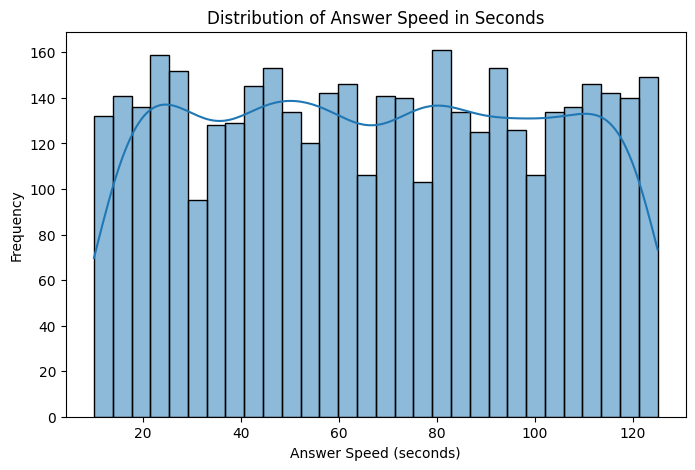

In [157]:
plt.figure(figsize=(8, 5))
sns.histplot(df['answer_speed_in_sec'].dropna(), bins=30, kde=True)
plt.title('Distribution of Answer Speed in Seconds')
plt.xlabel('Answer Speed (seconds)')
plt.ylabel('Frequency')
plt.show()

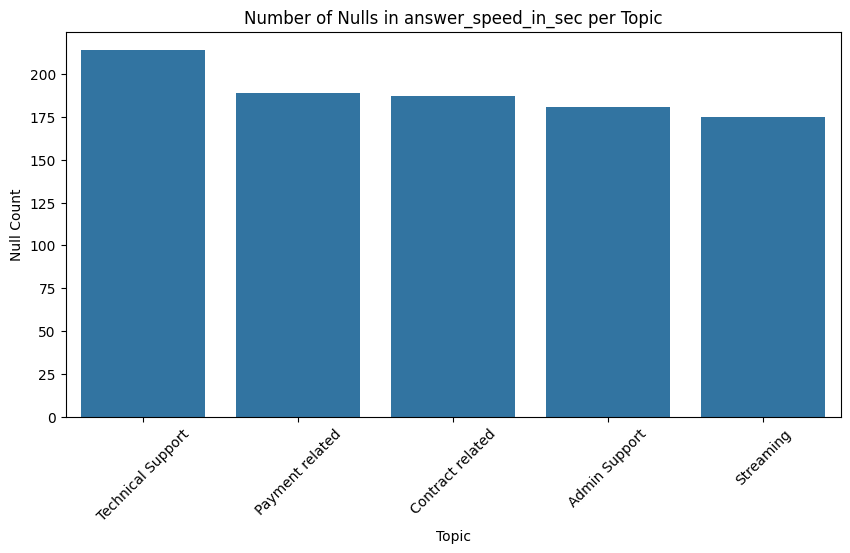

In [158]:
# Count nulls in 'answer_speed_in_sec' per topic
nulls_per_topic = df[df['answer_speed_in_sec'].isnull()].groupby('topic').size().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=nulls_per_topic.index, y=nulls_per_topic.values)
plt.title('Number of Nulls in answer_speed_in_sec per Topic')
plt.xlabel('Topic')
plt.ylabel('Null Count')
plt.xticks(rotation=45)
plt.show()

#### Apply SimpleImputer (mean strategy) for 'answer_speed_in_sec' grouped by 'topic'

In [159]:
df['answer_speed_in_sec'] = df.groupby('topic')['answer_speed_in_sec'].transform(lambda x: SimpleImputer(strategy='mean').fit_transform(x.values.reshape(-1, 1)).ravel())

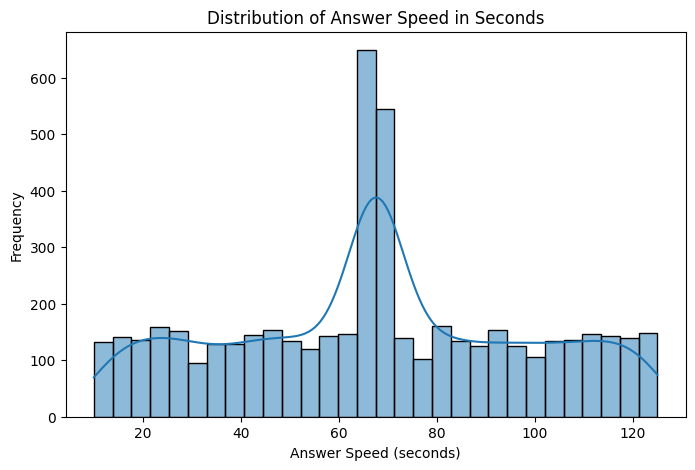

In [160]:
plt.figure(figsize=(8, 5))
sns.histplot(df['answer_speed_in_sec'].dropna(), bins=30, kde=True)
plt.title('Distribution of Answer Speed in Seconds')
plt.xlabel('Answer Speed (seconds)')
plt.ylabel('Frequency')
plt.show()

### 3.1.2 avg_talk_duration_sec
- AvgTalkDuration	

C:\Users\dariu\AppData\Local\Temp\ipykernel_8700\3836678576.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='topic', y='avg_talk_duration_sec', data=df, ci=None)


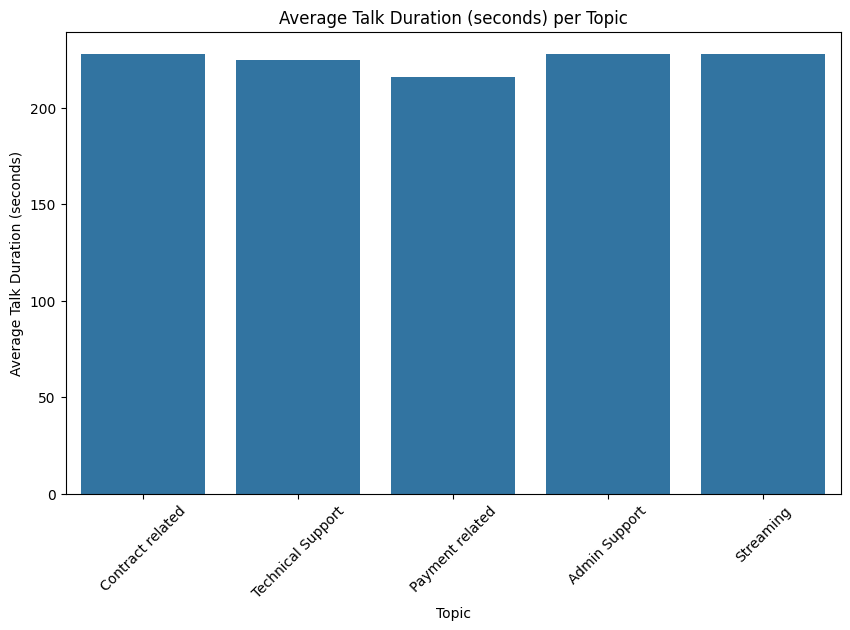

In [161]:
plt.figure(figsize=(10, 6))
sns.barplot(x='topic', y='avg_talk_duration_sec', data=df, ci=None)
plt.title('Average Talk Duration (seconds) per Topic')
plt.xlabel('Topic')
plt.ylabel('Average Talk Duration (seconds)')
plt.xticks(rotation=45)
plt.show()

C:\Users\dariu\AppData\Local\Temp\ipykernel_8700\3881037284.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='topic', y='avg_talk_duration_sec', data=df, ci=None)


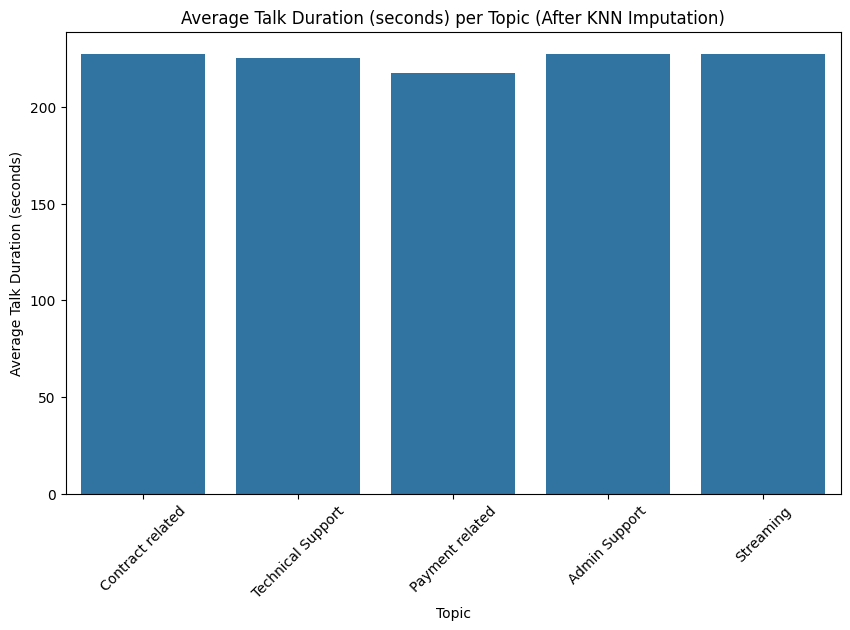

In [162]:
# KNN imputation for 'avg_talk_duration_sec'
knn_imputer = KNNImputer()
df['avg_talk_duration_sec'] = knn_imputer.fit_transform(df[['avg_talk_duration_sec']])

# Plot the imputed avg_talk_duration_sec by topic
plt.figure(figsize=(10, 6))
sns.barplot(x='topic', y='avg_talk_duration_sec', data=df, ci=None)
plt.title('Average Talk Duration (seconds) per Topic (After KNN Imputation)')
plt.xlabel('Topic')
plt.ylabel('Average Talk Duration (seconds)')
plt.xticks(rotation=45)
plt.show()

### 3.1.3 satisfaction_rating	
- Satisfaction rating	

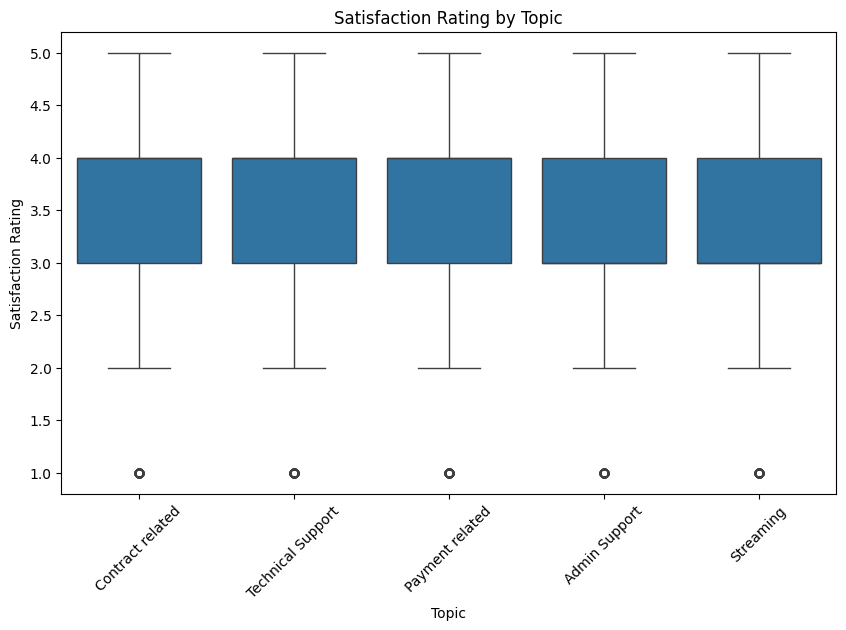

In [163]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic', y='satisfaction_rating', data=df)
plt.title('Satisfaction Rating by Topic')
plt.xlabel('Topic')
plt.ylabel('Satisfaction Rating')
plt.xticks(rotation=45)
plt.show()

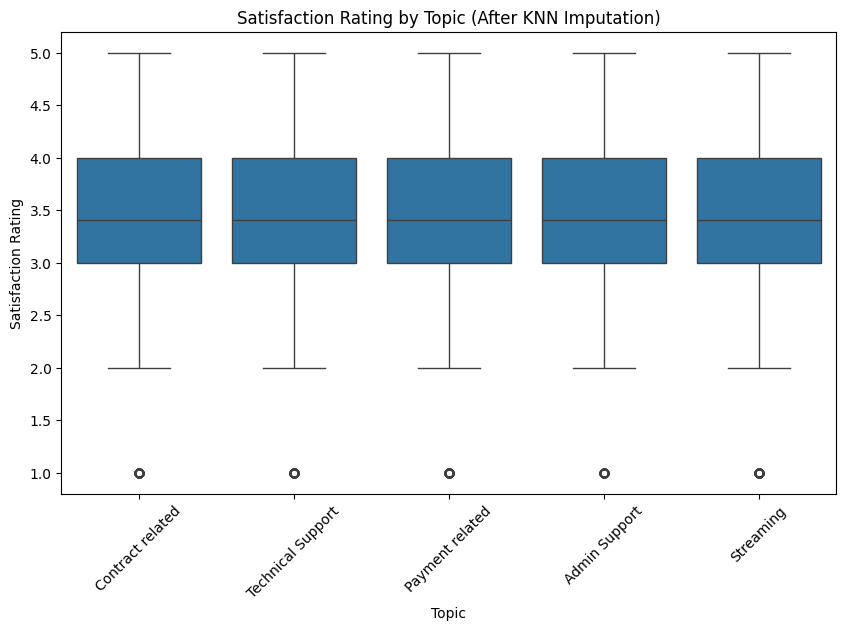

In [164]:
# KNN imputation for 'satisfaction_rating'
df['satisfaction_rating'] = knn_imputer.fit_transform(df[['satisfaction_rating']])

# Plot the imputed satisfaction_rating by topic
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic', y='satisfaction_rating', data=df)
plt.title('Satisfaction Rating by Topic (After KNN Imputation)')
plt.xlabel('Topic')
plt.ylabel('Satisfaction Rating')
plt.xticks(rotation=45)
plt.show()

In [165]:
null_count = df.isnull().sum()
null_percentage = (null_count / len(df)) * 100
null_report = pd.DataFrame({'Null Count': null_count, 'Null Percentage': null_percentage})
display(null_report)

,Null Count,Null Percentage
call_id,0,0.0
agent,0,0.0
date,0,0.0
time,0,0.0
topic,0,0.0
answered,0,0.0
resolved,0,0.0
answer_speed_in_sec,0,0.0
satisfaction_rating,0,0.0
avg_talk_duration_sec,0,0.0


## 3.2 Duplicates

In [166]:
# Check for duplicate rows in the DataFrame
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


# 4. EDA

### 4.1 Distribution of Calls by Topic

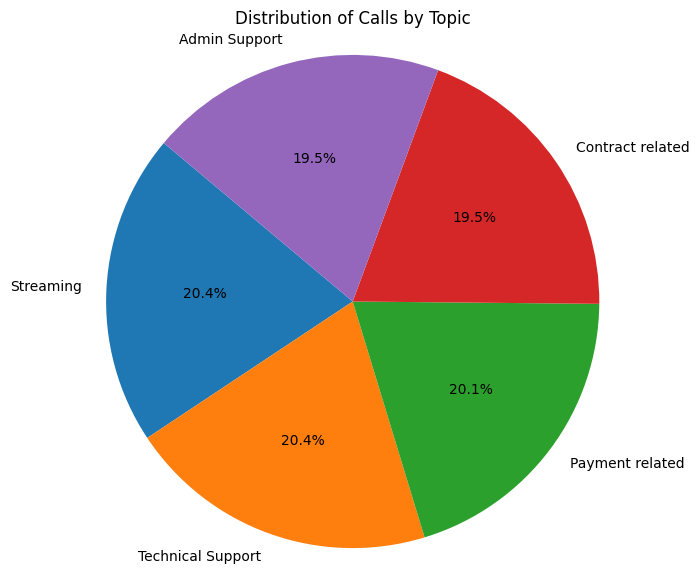

In [167]:
topic_counts = df['topic'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(topic_counts, labels=topic_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Calls by Topic')
plt.axis('equal')
plt.show()

We will get the payment related calls to extract payment related insights

In [168]:
# Create a DataFrame focusing on 'Payment related' topic
df_payment = df[df['topic'] == 'Payment related'].copy()

# Drop the 'topic' column from the new DataFrame
df_payment.drop(columns=['topic'], inplace=True)

In [169]:
df_payment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1007 entries, 4 to 4997
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   call_id                1007 non-null   object        
 1   agent                  1007 non-null   object        
 2   date                   1007 non-null   datetime64[ns]
 3   time                   1007 non-null   object        
 4   answered               1007 non-null   int64         
 5   resolved               1007 non-null   int64         
 6   answer_speed_in_sec    1007 non-null   float64       
 7   satisfaction_rating    1007 non-null   float64       
 8   avg_talk_duration_sec  1007 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 78.7+ KB


In [170]:
df_payment.head()

,call_id,agent,date,time,answered,resolved,answer_speed_in_sec,satisfaction_rating,avg_talk_duration_sec
4,ID0005,Becky,2021-01-01,10:00:29,1,1,95.000000,3.000000,60.000000
6,ID0007,Diane,2021-01-01,10:22:05,1,1,24.000000,2.000000,220.000000
7,ID0008,Diane,2021-01-01,10:22:05,1,1,22.000000,4.000000,38.000000
10,ID0011,Joe,2021-01-01,11:15:22,0,0,68.204156,3.403552,224.922792
11,ID0012,Greg,2021-01-01,11:15:22,1,1,50.000000,4.000000,32.000000


### 4.2 Calls by Hour of Day

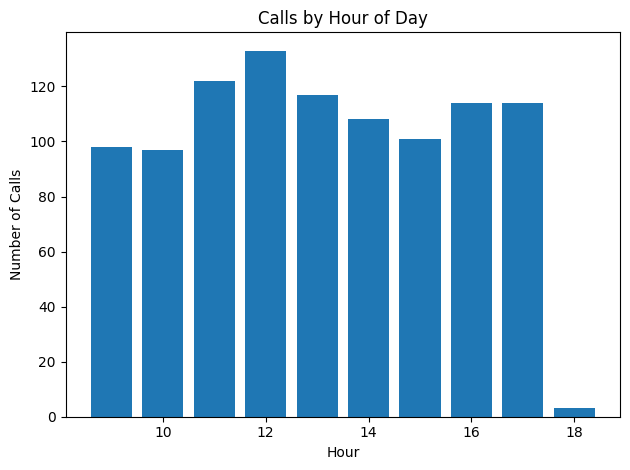

In [ ]:
df_payment['hour'] = pd.to_datetime(df_payment['time'], format='%H:%M:%S').dt.hour
hourly_counts = df_payment.groupby('hour').size()

plt.figure()
plt.bar(hourly_counts.index, hourly_counts.values)
plt.title('Calls by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Calls')
plt.tight_layout()
plt.show()


Payment related calls mostly occur during the afternoon with the 12th hour being the peak

### 4.3 Average Satisfaction vs Answer Speed

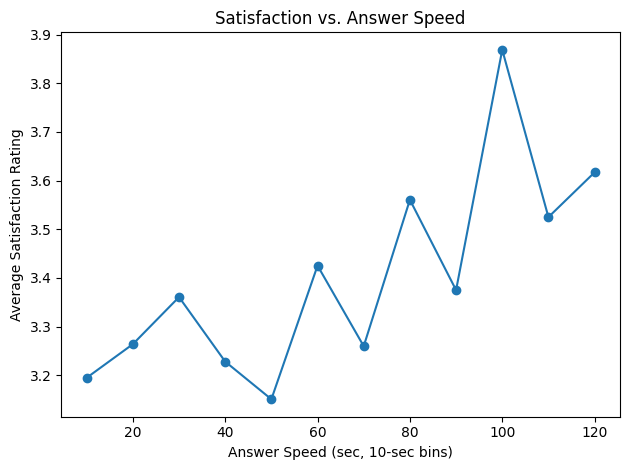

In [180]:
# bucket speeds into 10-sec bins
df_payment['speed_bin'] = (df_payment['answer_speed_in_sec'] // 10) * 10

# compute avg satisfaction per bin
avg_sat = (
    df_payment
    .groupby('speed_bin')['satisfaction_rating']
    .mean()
    .sort_index()
)

# plot
plt.figure()
plt.plot(avg_sat.index, avg_sat.values, '-o')
plt.xlabel('Answer Speed (sec, 10-sec bins)')
plt.ylabel('Average Satisfaction Rating')
plt.title('Satisfaction vs. Answer Speed')
plt.tight_layout()
plt.show()


Higher answer speed correlates to higher average satisfaction rating